#### Human Protein Atlas Image Classification

URL: https://www.kaggle.com/c/human-protein-atlas-image-classification

In [1]:
import os
import skimage
import pandas as pd
import numpy as np
from skimage.transform import resize
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import display, clear_output

In [2]:
def split_random(matrix, percent_train=70, percent_test=15):
    percent_validation = 100 - percent_train - percent_test

    if percent_validation < 0:
        percent_validation = 0

    rows = matrix.shape[0]
    np.random.shuffle(matrix)

    end_training = int(rows * percent_train / 100)    
    end_testing = end_training + int((rows * percent_test / 100))

    training = matrix[:end_training]
    testing = matrix[end_training:end_testing]
    validation = matrix[end_testing:]
    return training, testing, validation


In [3]:
from random import shuffle

def get_shuffled_x_y(type_dataset, percent_train=70, percent_test=15):
    multilabel = MultiLabelBinarizer()
    x_names = []
    x = []
    y = []
    df = pd.read_csv('datasets/' + type_dataset + '.csv', index_col=0)
    for indice_fila in df.iterrows():
        x_names.append(indice_fila[0])
        labels = (indice_fila[1]['Target']).split(" ")
        labels = [int(i) for i in labels]
        y.append(labels)
    
    y_multilabel = multilabel.fit_transform(y)
    total = len(x_names)
    total_train = int((percent_train * total) / 100)
    total_test = int((percent_test * total) / 100)
    total_val = total - total_train - total_test
    x_names = np.array(x_names)
    
    shuffle = np.arange(x_names.shape[0])
    np.random.shuffle(shuffle)
    x_names = x_names[shuffle]
    y_multilabel = y_multilabel[shuffle]
    
    # Train
    last_train = total_train
    x_train = x_names[0:last_train]
    y_train = y_multilabel[0:last_train]
    
    # Test
    first_test = last_train
    last_test = first_test + total_test
    x_test = x_names[first_test:last_test]
    y_test = y_multilabel[first_test:last_test]
    
    # Validation
    first_val = last_test
    last_val = first_val + total_val
    x_val = x_names[first_val:last_val]
    y_val = y_multilabel[first_val:last_val]
    
    return x_train, y_train, x_test, y_test, x_val, y_val


In [4]:
def get_image(type_dataset, x):
    result_x = []
    i = 0
    for names in x:
        if(i % 100 == 0):
            clear_output(wait=True)
            display(str(i) + ' / ' + str(len(x)))
        i = i + 1
        path = './datasets/' + type_dataset + '/' + names
    
        img_blue = np.array(Image.open(path + '_blue.png'))
        img_blue = np.asarray(skimage.transform.resize(img_blue, (150, 150, 3)))
        
        img_green = np.array(Image.open(path + '_green.png'))
        img_green = np.asarray(skimage.transform.resize(img_green, (150, 150, 3)))
        
        img_red = np.array(Image.open(path +'_red.png'))
        img_red = np.asarray(skimage.transform.resize(img_red, (150, 150, 3)))
        
        img_yellow = np.array(Image.open(path + '_yellow.png'))
        img_yellow = np.asarray(skimage.transform.resize(img_yellow, (150, 150, 3)))
    
        result = np.concatenate((img_blue, img_green, img_red, img_yellow), axis=2)
        result_x.append(result)

    print("FIN")
    return np.array(result_x)


In [5]:
x_label_train, y_train, x_label_test, y_test, x_label_val, y_val = get_shuffled_x_y('train')

In [10]:
x_train = get_image('train', x_label_train)

'21700 / 21750'

FIN


In [7]:
x_test = get_image('train', x_label_test)

'4600 / 4660'

FIN


In [8]:
x_val = get_image('train', x_label_val)

'4600 / 4662'

FIN


In [16]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint

import sys
sys.path.insert(0, '../../Utils')
from fnn_helper import PlotLosses

In [13]:
dropout = 0.25
output_size = y_train.shape[1]

model = Sequential()
model.add(Convolution2D(filters=6, strides=1, kernel_size=6, padding='same',input_shape=(150,150,12)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=12, strides=2, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Convolution2D(filters=24, strides=2, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(dropout))
model.add(Dense(output_size, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 6)       2598      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 6)       24        
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 6)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 12)        1812      
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 12)        48        
_________________________________________________________________
activation_2 (Activation)    (None, 75, 75, 12)        0         
__________

In [14]:
lr = 0.001
plot_interval = 1
epochs = 80
batch_size = 512

adam = optimizers.Adam(lr=lr)
model.compile(loss = 'binary_crossentropy', optimizer=adam, metrics=['accuracy'])

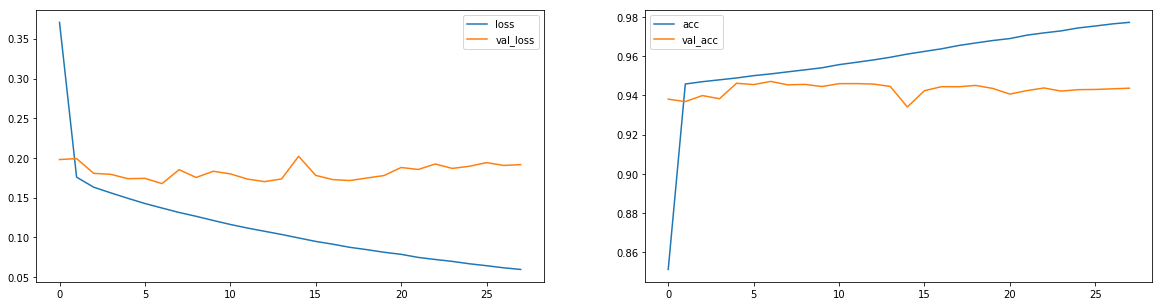


Epoch 00028: val_loss did not improve
Epoch 29/80
 6144/21750 [=======>......................] - ETA: 28:14 - loss: 0.0554 - acc: 0.9795

KeyboardInterrupt: 

In [17]:
checkpointer = ModelCheckpoint(filepath='Test1.weights.best.hdf5', verbose=1, save_best_only=True)
plot_losses = PlotLosses(plot_interval=plot_interval, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)

model.fit(x_train, 
          y_train,
          epochs=epochs, 
          batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[plot_losses, 
                     checkpointer],
         )

In [18]:
model.load_weights('Test1.weights.best.hdf5')
score = model.evaluate(x_val, y_val, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.16766613087061902
accuracy:  0.9468192771901802


In [23]:
x_names = []
x = []
y = []
df = pd.read_csv('datasets/sample_submission.csv', index_col=0)
for indice_fila in df.iterrows():
    x_names.append(indice_fila[0])


In [24]:
x_sample_submission = get_image('test', x_names)

'11700 / 11702'

FIN


In [141]:
def generate_csv(labels, data, name, limit=0.1):
    ids = []
    predicted = []
    index = 0
    for x_label in labels:
        ids.append(x_label)
        predicts = model.predict(data[index:index+1])
        predict_index = 0
        predict_label = ""
        for predict in predicts[0]:
            if(predict >= limit):
                predict_label = predict_label + str(predict_index) + " "
            predict_index = predict_index + 1
        predicted.append(predict_label.strip())
        index = index + 1
    
    d = {'Id': ids, 'Predicted': predicted}
    df = pd.DataFrame(data=d)
    df.to_csv('./' + name + '-' + str(limit) + '.csv', index=False)
    

In [142]:
generate_csv(x_names, x_sample_submission, 'result-test1', limit=0.2)